# Chapter 10: Machine Learning with MLlib
Christoph Windheuser    
June, 2022   
Python examples of chapter 10 (page 285 ff) in the book *Learning Spark*

In [1]:
# Import required python spark libraries
import pyspark
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline


In [2]:
# create a SparkSession
# This requires access to the internet. If executed offline, an error is thrown

spark = (SparkSession \
         .builder \
         .appName("Chapter_10") \
         .getOrCreate())


# Read the Database into a DataFrame
Page 291

In [3]:
filePath = "../DB_Spark/LearningSparkV2/databricks-datasets/learning-spark-v2/sf-airbnb/sf-airbnb-clean.parquet"


In [4]:
airbnbDF = spark.read.parquet(filePath)

In [5]:
# Show the entire DataFrame columns and the first 5 lines:
airbnbDF.show(5)

+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|

In [6]:
# Show only a subset of columns:
airbnbDF.select("neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms", "number_of_reviews", "price").show(5)


+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [7]:
# Show the schema of the DataFrame:
airbnbDF.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [8]:
# Show the number of rows of the DataFrame:
airbnbDF.count()

7146

# Creating Training and Test Data Sets
Page 291

In [9]:
trainDF, testDF = airbnbDF.randomSplit([0.8, 0.2], seed=42)

print (f"There are ${trainDF.count()} rows in the training set, and ${testDF.count()} rows in the test set.")


There are $5780 rows in the training set, and $1366 rows in the test set.


# Preparing the Features with Transformers
Page 293

In [10]:
vecAssembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
vecTrainDF   = vecAssembler.transform(trainDF)


In [11]:
vecTrainDF.show()

+-----------------+-------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+-------------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+--------+
|host_is_superhost|cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|     bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review

In [12]:
vecTrainDF.select("bedrooms", "features", "price").show(10)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]| 95.0|
|     1.0|   [1.0]|250.0|
|     3.0|   [3.0]|250.0|
|     1.0|   [1.0]|115.0|
|     1.0|   [1.0]|105.0|
|     1.0|   [1.0]| 86.0|
|     1.0|   [1.0]|100.0|
|     2.0|   [2.0]|220.0|
+--------+--------+-----+
only showing top 10 rows



# Building a Model with an Estimator
Page 295

In [13]:
lr      = LinearRegression(featuresCol="features", labelCol="price")
lrModel = lr.fit(vecTrainDF)


### Inspecting the Learned Linear Regression Model

In [14]:
m = np.round(lrModel.coefficients[0], 2)
b = np.round(lrModel.intercept, 2)
print(f"""The formular for the linear regression line is:
price = {m} * bedrooms + {b}""")


The formular for the linear regression line is:
price = 123.68 * bedrooms + 47.51


# Creating a Pipeline
Page 296

In [15]:
pipeline      = Pipeline (stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)


### Apply the learned Pipeline to our test data

In [16]:
predDF = pipelineModel.transform(testDF)


In [17]:
predDF.select("bedrooms", "features", "price", "prediction").show(10)


+--------+--------+------+------------------+
|bedrooms|features| price|        prediction|
+--------+--------+------+------------------+
|     1.0|   [1.0]|  85.0|171.18598011578285|
|     1.0|   [1.0]|  45.0|171.18598011578285|
|     1.0|   [1.0]|  70.0|171.18598011578285|
|     1.0|   [1.0]| 128.0|171.18598011578285|
|     1.0|   [1.0]| 159.0|171.18598011578285|
|     2.0|   [2.0]| 250.0|294.86172649777757|
|     1.0|   [1.0]|  99.0|171.18598011578285|
|     1.0|   [1.0]|  95.0|171.18598011578285|
|     1.0|   [1.0]| 100.0|171.18598011578285|
|     1.0|   [1.0]|2010.0|171.18598011578285|
+--------+--------+------+------------------+
only showing top 10 rows



# One-Hot Encoding
Page 297

### Feature Engineering    
Convert categorical features into One-Hot Encoding features and add all double values to the feature vectors.


In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [19]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols   = [x + "OHE"   for x in categoricalCols]


In [20]:
stringIndexer = StringIndexer(inputCols = categoricalCols,
                             outputCols = indexOutputCols,
                             handleInvalid="skip")
oheEncoder    = OneHotEncoder(inputCols = indexOutputCols,
                             outputCols = oheOutputCols)


In [21]:
numericCols = [field for (field, dataType) in trainDF.dtypes
                if ((dataType == "double") & (field != "price"))]


In [22]:
assemblerInputs = oheOutputCols + numericCols


In [23]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [24]:
# The above lines could be replaced by:
# from pyspark.ml.feature import RFormula
# rFormula = RFormula(formula="price ~ .", featuresCol="features", handleInvalid="skip")


### Create a Linear Regression Model and a Training and Evaluation Pipeline
Page 301

In [25]:
lr = LinearRegression(labelCol="price", featuresCol="features")
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

# Or if you use the RFormula:
# pipeline = Pipeline(stage = [rFormula, lr])


In [26]:
pipelineModel = pipeline.fit(trainDF)


In [27]:
predDF = pipelineModel.transform(testDF)

In [28]:
predDF.select("features", "price", "prediction").show(5)

+--------------------+-----+------------------+
|            features|price|        prediction|
+--------------------+-----+------------------+
|(98,[0,3,6,22,43,...| 85.0| 55.24365707389188|
|(98,[0,3,6,22,43,...| 45.0|23.357685914717877|
|(98,[0,3,6,22,43,...| 70.0|28.474464479034395|
|(98,[0,3,6,12,42,...|128.0| -91.6079079594947|
|(98,[0,3,6,12,43,...|159.0| 95.05688229945372|
+--------------------+-----+------------------+
only showing top 5 rows



# Evaluating the Model with Root Mean Square Error (RMSE)
Page 302

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator (
    predictionCol = "prediction",
    labelCol      = "price",
    metricName    = "rmse")

rmse = regressionEvaluator.evaluate(predDF)
print (f"RMSE is {rmse:.1f}")


RMSE is 220.6


# Calculate the Average Price as a Baseline

In [30]:

aveDF = trainDF.select(avg("price"))
aveDF.show()


+------------------+
|        avg(price)|
+------------------+
|214.47249134948098|
+------------------+



In [31]:
average = aveDF.collect()[0][0]
print (average)

214.47249134948098


In [32]:
from pyspark.sql.functions import lit

testDF = testDF.withColumn('average_price', lit(average))


In [33]:
testDF.select("price", "average_price").show(5)

+-----+------------------+
|price|     average_price|
+-----+------------------+
| 85.0|214.47249134948098|
| 45.0|214.47249134948098|
| 70.0|214.47249134948098|
|128.0|214.47249134948098|
|159.0|214.47249134948098|
+-----+------------------+
only showing top 5 rows



In [34]:
regressionEvaluator = RegressionEvaluator (
    predictionCol = "average_price",
    labelCol      = "price",
    metricName    = "rmse")

rmse = regressionEvaluator.evaluate(testDF)
print (f"RMSE is {rmse:.1f}")


RMSE is 240.7


## Calculate R<sup>2</sup>
Page 304

In [35]:
regressionEvaluator = RegressionEvaluator (
    predictionCol = "prediction",
    labelCol      = "price",
    metricName    = "r2")

r2 = regressionEvaluator.evaluate(predDF)
print (f"R^2 is {r2}")

R^2 is 0.16043316698848087


## Exercise: Learn with a log-normally distributed price
Page 305

### 1. Show distribution of "price"

In [37]:
trainDF.select("price").show(10)

+-----+
|price|
+-----+
|200.0|
|130.0|
| 95.0|
|250.0|
|250.0|
|115.0|
|105.0|
| 86.0|
|100.0|
|220.0|
+-----+
only showing top 10 rows



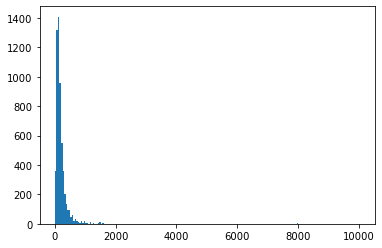

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show histogram of the 'price' column
bins, counts = trainDF.select('price').rdd.flatMap(lambda x: x).histogram(200)

# This is a bit awkward but I believe this is the correct way to do it 
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.show()

### 2. Caluclate the log of price as a new column

In [47]:
trainDF = trainDF.withColumn('log_price', log('price'))


In [48]:
trainDF.select("price", "log_price").show(10)

+-----+-----------------+
|price|        log_price|
+-----+-----------------+
|200.0|5.298317366548036|
|130.0|4.867534450455582|
| 95.0|4.553876891600541|
|250.0|5.521460917862246|
|250.0|5.521460917862246|
|115.0| 4.74493212836325|
|105.0|4.653960350157523|
| 86.0|4.454347296253507|
|100.0|4.605170185988092|
|220.0|5.393627546352362|
+-----+-----------------+
only showing top 10 rows



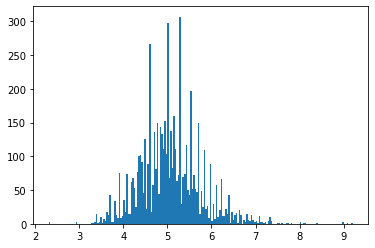

In [50]:
# Show histogram of the 'price' column
bins, counts = trainDF.select('log_price').rdd.flatMap(lambda x: x).histogram(200)

# This is a bit awkward but I believe this is the correct way to do it 
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.show()

### 3. Train the Model on the log price

In [51]:
lr = LinearRegression(labelCol="log_price", featuresCol="features")
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])


In [52]:
pipelineModel = pipeline.fit(trainDF)


In [53]:
predDF = pipelineModel.transform(testDF)

In [59]:
predDF.select("features", "price", "prediction").show(10)

+--------------------+------+------------------+
|            features| price|        prediction|
+--------------------+------+------------------+
|(98,[0,3,6,22,43,...|  85.0| 4.644425529745689|
|(98,[0,3,6,22,43,...|  45.0| 4.223594858687562|
|(98,[0,3,6,22,43,...|  70.0| 4.248280556674246|
|(98,[0,3,6,12,42,...| 128.0|3.8921581128135756|
|(98,[0,3,6,12,43,...| 159.0| 4.608476041020452|
|(98,[0,3,6,12,43,...| 250.0| 5.365868119786427|
|(98,[0,3,6,11,42,...|  99.0| 5.084838593929874|
|(98,[0,3,6,31,42,...|  95.0| 5.008339179369244|
|(98,[0,3,6,28,42,...| 100.0| 4.154386449584621|
|(98,[0,3,6,28,43,...|2010.0| 5.434322576497891|
+--------------------+------+------------------+
only showing top 10 rows



In [58]:
predDF = predDF.withColumn('exp_prediction', exp('prediction'))


In [60]:
predDF.select("features", "price", "prediction", "exp_prediction").show(10)

+--------------------+------+------------------+------------------+
|            features| price|        prediction|    exp_prediction|
+--------------------+------+------------------+------------------+
|(98,[0,3,6,22,43,...|  85.0| 4.644425529745689|104.00360164521213|
|(98,[0,3,6,22,43,...|  45.0| 4.223594858687562| 68.27849517736573|
|(98,[0,3,6,22,43,...|  70.0| 4.248280556674246|    69.98497363677|
|(98,[0,3,6,12,42,...| 128.0|3.8921581128135756|49.016555716669316|
|(98,[0,3,6,12,43,...| 159.0| 4.608476041020452|100.33113253975256|
|(98,[0,3,6,12,43,...| 250.0| 5.365868119786427|213.97691166520218|
|(98,[0,3,6,11,42,...|  99.0| 5.084838593929874| 161.5538613592169|
|(98,[0,3,6,31,42,...|  95.0| 5.008339179369244|149.65597789919877|
|(98,[0,3,6,28,42,...| 100.0| 4.154386449584621| 63.71286150055549|
|(98,[0,3,6,28,43,...|2010.0| 5.434322576497891| 229.1375725111251|
+--------------------+------+------------------+------------------+
only showing top 10 rows



### Evaluating the Model with Root Mean Square Error (RMSE)

In [61]:
regressionEvaluator = RegressionEvaluator (
    predictionCol = "exp_prediction",
    labelCol      = "price",
    metricName    = "rmse")

rmse = regressionEvaluator.evaluate(predDF)
print (f"RMSE is {rmse:.1f}")


RMSE is 208.2


### Calculate R<sup>2</sup>

In [62]:
regressionEvaluator = RegressionEvaluator (
    predictionCol = "exp_prediction",
    labelCol      = "price",
    metricName    = "r2")

r2 = regressionEvaluator.evaluate(predDF)
print (f"R^2 is {r2}")

R^2 is 0.25186821749888966


### Results
The new model with log-normally distributed prices performs better:    

Metrics   | lin price | log price | comment
:---|:---|:---|:---
SMSE          | 220.6 | 208.2     | *lower is better*
R<sup>2</sup> | 0.160 | 0.252     | *higher is better*


## Saving and Loading Models
Page 306

In [64]:
# Saving the model to disk:
pipelinePath = "/tmp/lr-pipeline-model"
pipelineModel.write().overwrite().save(pipelinePath)

In [65]:
# Loading the model back from disk:
from pyspark.ml import PipelineModel
savedPipelineModel = PipelineModel.load(pipelinePath)